In [3]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data_dict = pd.read_excel('data/LCDataDictionary.xlsx')

df = (pd.read_csv('data/loan.csv', low_memory=False)
      .assign(issue_d=lambda x: x.issue_d.astype('datetime64')))

In [3]:
print("Date Range: %s to %s" % (df.issue_d.min().isoformat()[:-9],
                                df.issue_d.max().isoformat()[:-9]))

Date Range: 2007-06-01 to 2015-12-01


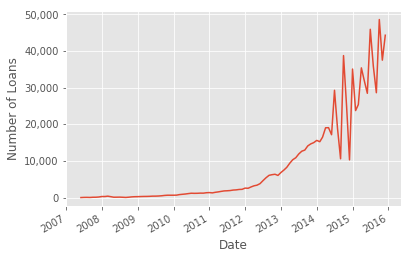

In [6]:
plt.style.use('ggplot')
ax = df.issue_d.value_counts().plot()
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Loans')
plt.show()

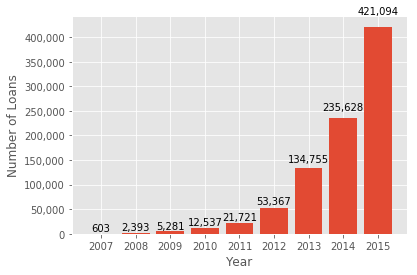

In [7]:
plt.style.use('ggplot')
year_cnts = (df.assign(year=lambda x: x.issue_d.dt.year)
             .groupby('year').size()
             .reset_index(name='num_loans'))
fig = plt.figure()
ax = fig.add_subplot(111)
rects = ax.bar(year_cnts.year, year_cnts.num_loans, align='center')
ax.set_xticks(year_cnts.year)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Year')
ax.set_ylabel('Number of Loans')
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '{:,}'.format(int(height)), ha='center', va='bottom')

plt.show()

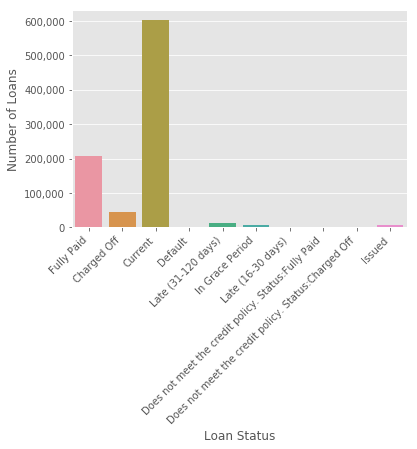

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(labels=df.loan_status, rotation=45, ha='right')
sns.countplot('loan_status', data=df, ax=ax)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Number of Loans')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

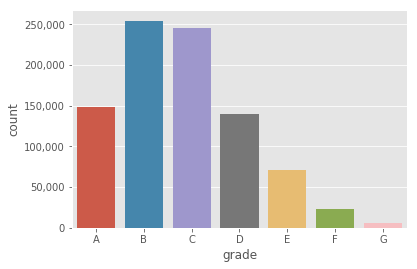

In [9]:
order = (df.grade.drop_duplicates()
         .sort_values()
         .values
         .tolist())
ax = sns.countplot('grade', data=df, order=order)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

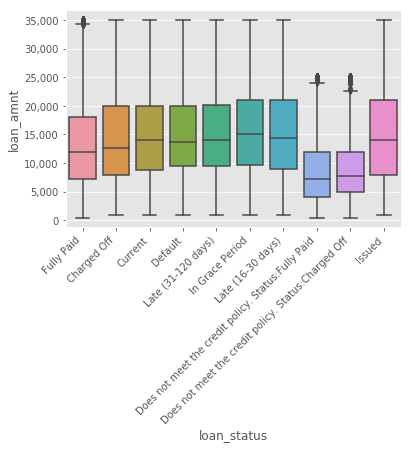

In [85]:
ax = sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.xticks(rotation=45, ha='right')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

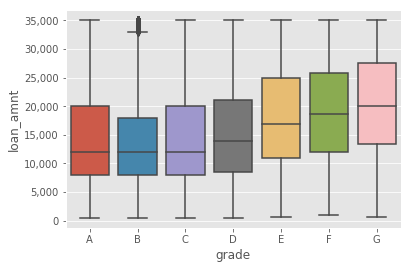

In [82]:
order = (df.grade.drop_duplicates()
         .sort_values()
         .values
         .tolist())
ax = sns.boxplot(x='grade', y='loan_amnt', data=df, order=order)
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

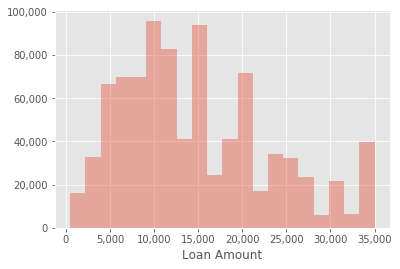

In [12]:
ax = sns.distplot(df.loan_amnt.values.round().astype('int64'), bins=20, kde=False)
ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Loan Amount')
plt.show()

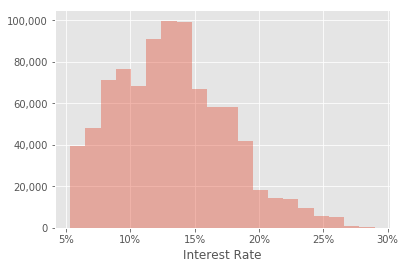

In [11]:
ax = sns.distplot(df.int_rate, bins=20, kde=False)
ax.set_xticklabels(['{:}%'.format(int(x)) for x in ax.get_xticks().tolist()])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xlabel('Interest Rate')
plt.show()

Default:     120 days past due

Charged Off: 150 days past due

In [4]:
df.loan_status.value_counts().apply('{:,}'.format)

Current                                                601,779
Fully Paid                                             207,723
Charged Off                                             45,248
Late (31-120 days)                                      11,591
Issued                                                   8,460
In Grace Period                                          6,253
Late (16-30 days)                                        2,357
Does not meet the credit policy. Status:Fully Paid       1,988
Default                                                  1,219
Does not meet the credit policy. Status:Charged Off        761
Name: loan_status, dtype: object

In [6]:
df.groupby('loan_status')['issue_d'].max().sort_values()

loan_status
Does not meet the credit policy. Status:Charged Off   2010-12-01
Does not meet the credit policy. Status:Fully Paid    2010-12-01
Default                                               2015-08-01
Charged Off                                           2015-09-01
Late (31-120 days)                                    2015-11-01
Current                                               2015-12-01
Fully Paid                                            2015-12-01
In Grace Period                                       2015-12-01
Issued                                                2015-12-01
Late (16-30 days)                                     2015-12-01
Name: issue_d, dtype: datetime64[ns]

In [9]:
statuses = ['Fully Paid', 'Charged Off', 'Default']
df = df.loc[df.loan_status.isin(statuses), ]

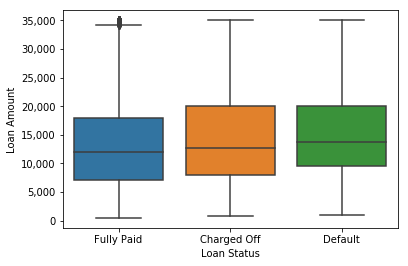

In [13]:
ax = sns.boxplot(x='loan_status', y='loan_amnt', data=df)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Amount')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

/home/bf2398/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


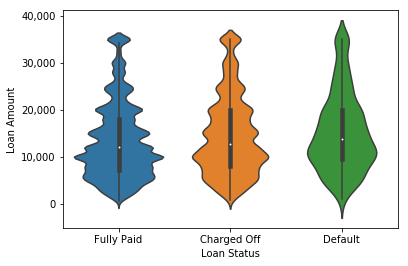

In [28]:
ax = sns.violinplot(x='loan_status', y='loan_amnt', data=df)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Loan Amount')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

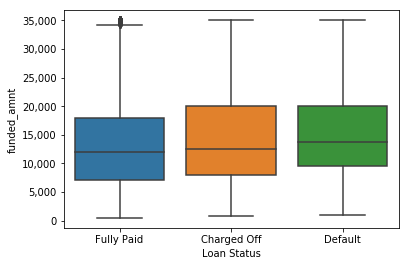

In [33]:
ax = sns.boxplot(x='loan_status', y='funded_amnt', data=df)
ax.set_xlabel('Loan Status')
ax.set_ylabel('funded_amnt')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

/home/bf2398/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


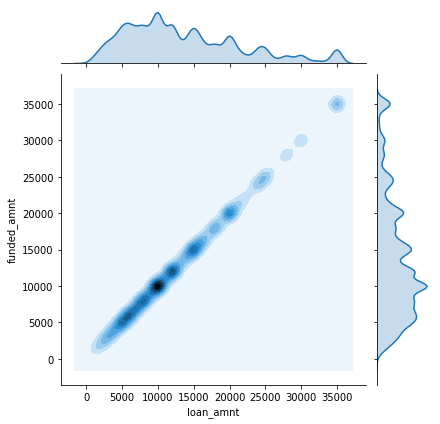

In [38]:
sns.jointplot(x="loan_amnt", y="funded_amnt", data=df, kind="kde")

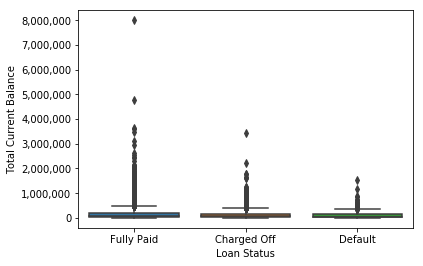

In [39]:
ax = sns.boxplot(x='loan_status', y='tot_cur_bal', data=df)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Total Current Balance')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

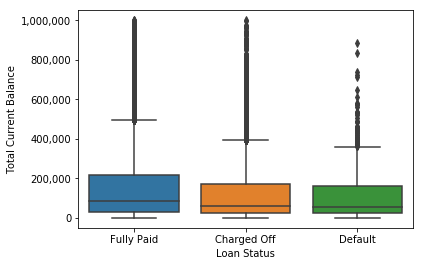

In [40]:
ax = sns.boxplot(x='loan_status', y='tot_cur_bal', data=df.loc[df.tot_cur_bal < 1000000, ])
ax.set_xlabel('Loan Status')
ax.set_ylabel('Total Current Balance')
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
plt.show()

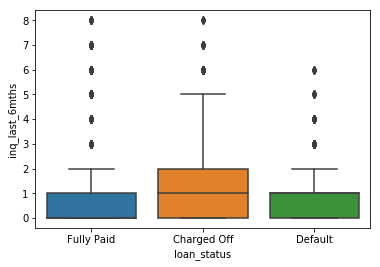

In [71]:
sns.boxplot(x='loan_status', y='inq_last_6mths', data=df)
plt.show()

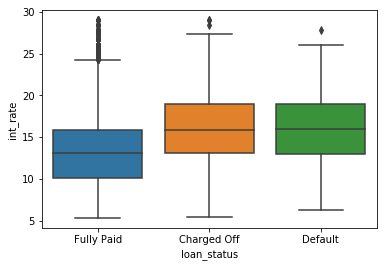

In [70]:
sns.boxplot(x='loan_status', y='int_rate', data=df)
plt.show()

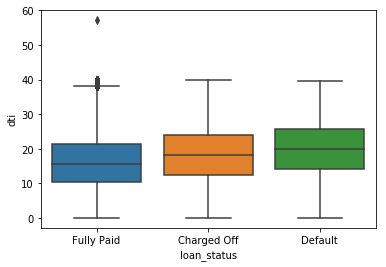

In [69]:
sns.boxplot(x='loan_status', y='dti', data=df)
plt.show()

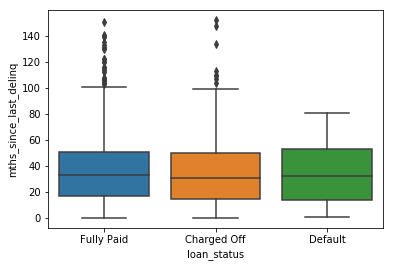

In [68]:
sns.boxplot(x='loan_status', y='mths_since_last_delinq', data=df)
plt.show()

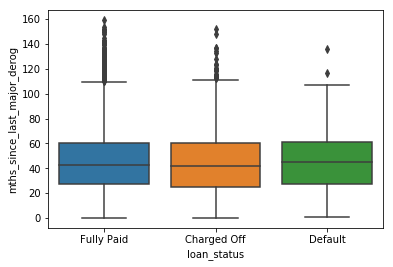

In [67]:
sns.boxplot(x='loan_status', y='mths_since_last_major_derog', data=df)
plt.show()

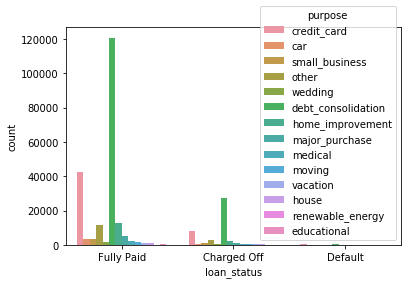

In [66]:
sns.countplot(x='loan_status', hue='purpose', data=df)
plt.show()

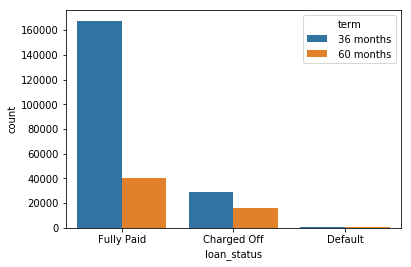

In [73]:
sns.countplot(x='loan_status', hue='term', data=df)
plt.show()